## Credit Card Kaggle Anomaly Detection 

### Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

###  Importing Libraries

In [120]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score,precision_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

### Importing Dataset

In [121]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [122]:
df.isnull().values.any()

False

## The classes are heavily skewed we need to solve this issue later.

In [123]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


### Note:
Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

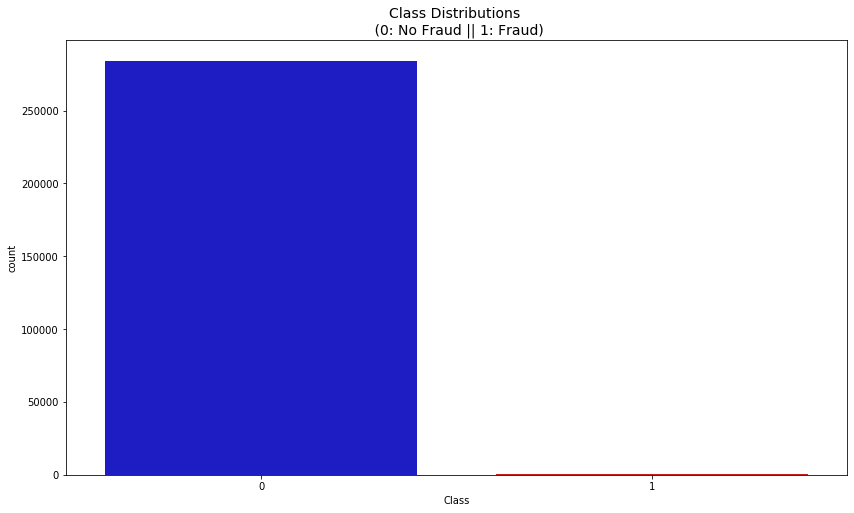

In [124]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

### Get the Fraud and the normal dataset 

In [125]:
fraud = df[df['Class']==1]

normal = df[df['Class']==0]

In [126]:
fraud.shape

(492, 31)

In [127]:
normal.shape

(284315, 31)

## We need to analyze more amount of information from the transaction data
### How different are the amount of money used in different transaction classes?

In [128]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [129]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

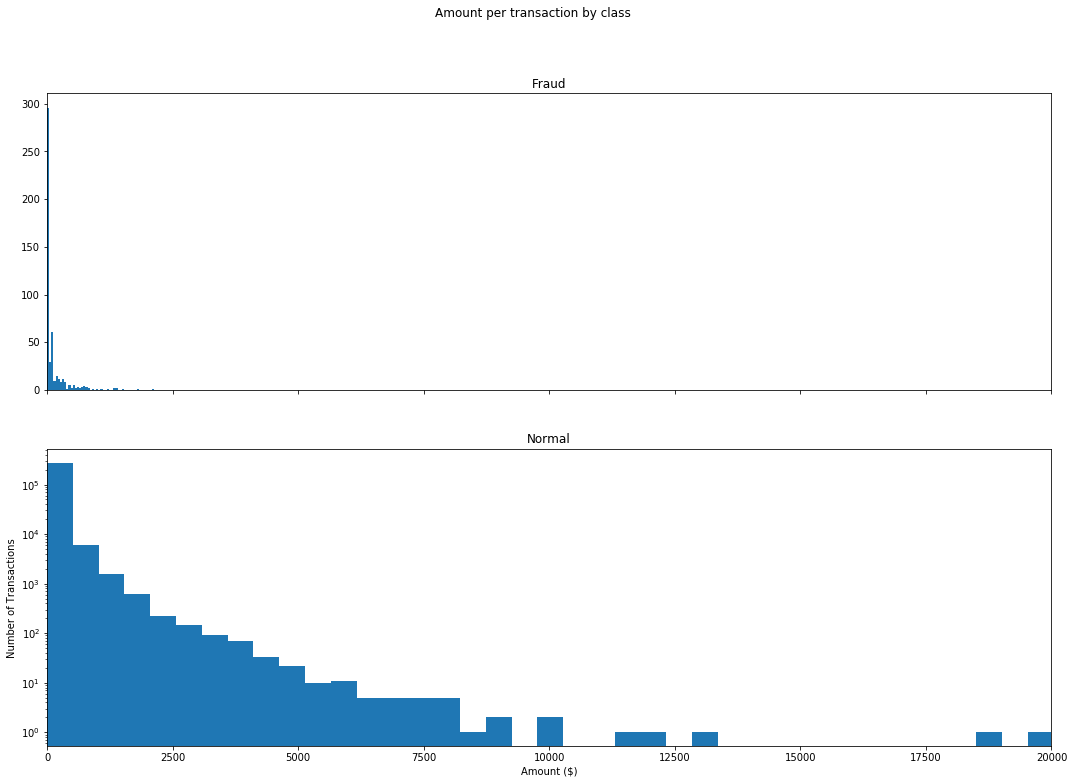

In [130]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18,12))
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

## We will check do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation

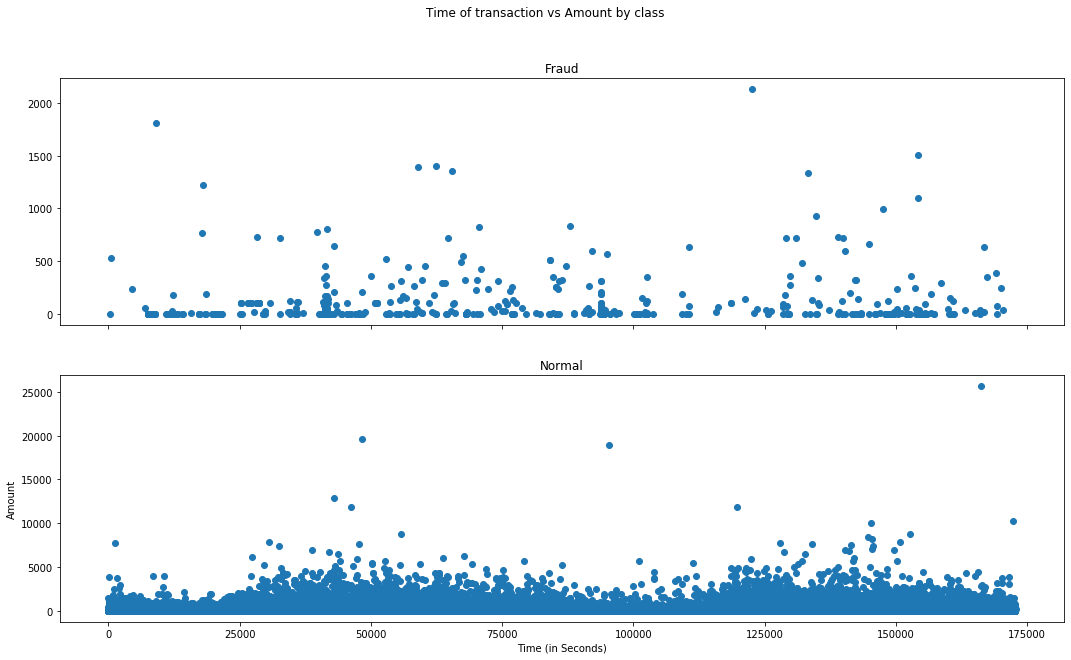

In [131]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18,10))
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

## Take some sample of the data

In [132]:
df1 = df.sample(frac = 0.1,random_state=1)

df1.shape

(28481, 31)

In [133]:
df.shape

(284807, 31)

## Determine the number of fraud and valid transactions in the dataset

In [134]:
Fraud = df1[df1['Class']==1]

Valid = df1[df1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [135]:
print('The Outliner Fraction is',outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

The Outliner Fraction is 0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


## Correlation Heat Map

Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample) in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

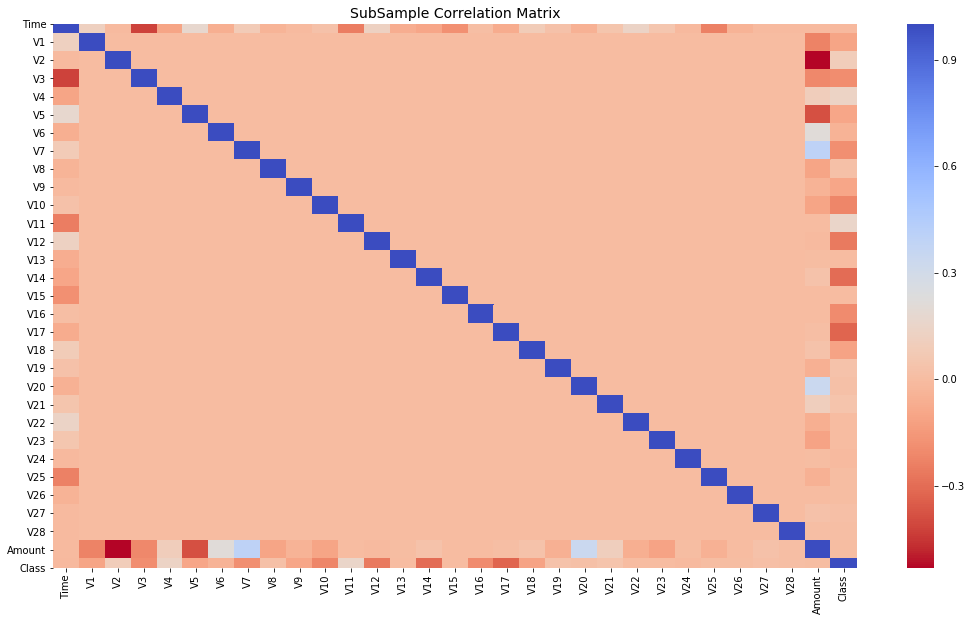

In [136]:
f, (ax2) = plt.subplots(1, 1, figsize=(18,10))

sub_sample_corr = df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()

## Summary and Explanation:

1. Negative Correlations: V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.
2. Positive Correlations: V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. 

## BoxPlots: 

We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions. 

## Negative Correlations with our Class 
### (The lower our feature value the more likely it will be a fraud transaction)

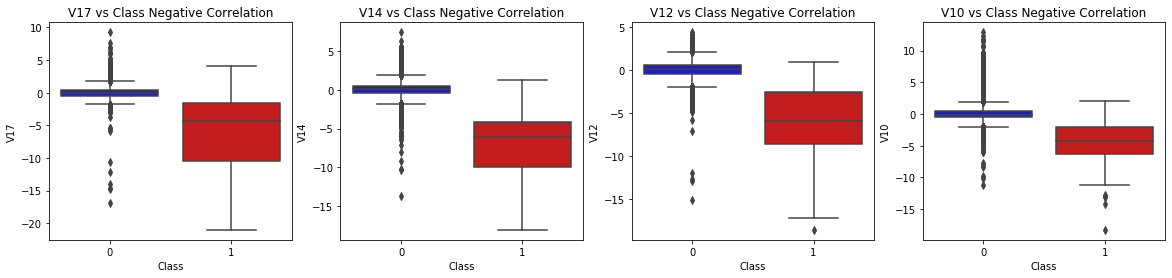

In [137]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=df1, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=df1, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=df1, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=df1, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

## Positive Correlations with our Class
### (The higher the feature the probability increases that it will be a fraud transaction)

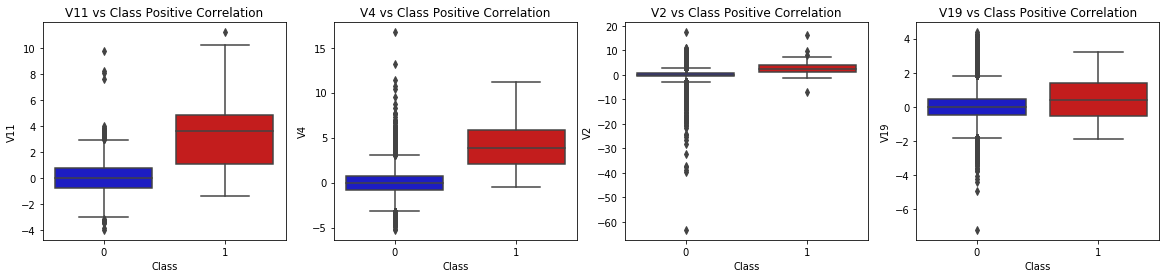

In [138]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data= df1, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data= df1, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data= df1, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data= df1, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## Anomaly Detection:

Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.


Outlier Removal Tradeoff:

The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.

## Summary:

1. Visualize Distributions: We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. V17 is the only feature that has a Gaussian distribution compared to features V14 and V12.
2. Conditional Dropping: Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed.
3. Boxplot Representation: Visualize through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount.

##### Note: After implementing outlier reduction our accuracy has been improved by over 3%! Some outliers can distort the accuracy of our models but remember, we have to avoid an extreme amount of information loss or else our model runs the risk of underfitting.

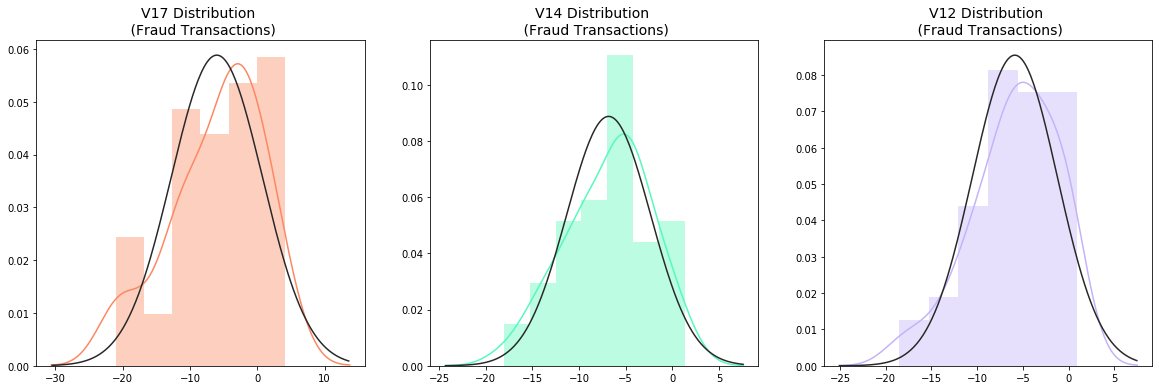

In [139]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v17_fraud_dist = df1['V17'].loc[df1['Class'] == 1].values
sns.distplot(v17_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V17 Distribution \n (Fraud Transactions)', fontsize=14)

v14_fraud_dist = df1['V14'].loc[df1['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)


v12_fraud_dist = df1['V12'].loc[df1['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

## Create independent and Dependent Features

In [141]:
X = df1.drop(['Class'], axis='columns')
y = df1['Class']

In [142]:
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
169876,119907.0,-0.611712,-0.769705,-0.149759,-0.224877,2.028577,-2.019887,0.292491,-0.523020,0.358468,...,-0.196039,-0.075208,0.045536,0.380739,0.023440,-2.220686,-0.201146,0.066501,0.221180,1.79
127467,78340.0,-0.814682,1.319219,1.329415,0.027273,-0.284871,-0.653985,0.321552,0.435975,-0.704298,...,-0.009041,-0.128619,-0.368565,0.090660,0.401147,-0.261034,0.080621,0.162427,0.059456,1.98
137900,82382.0,-0.318193,1.118618,0.969864,-0.127052,0.569563,-0.532484,0.706252,-0.064966,-0.463271,...,0.206028,-0.305402,-0.774704,-0.123884,-0.495687,-0.018148,0.121679,0.249050,0.092516,0.89
21513,31717.0,-1.328271,1.018378,1.775426,-1.574193,-0.117696,-0.457733,0.681867,-0.031641,0.383872,...,0.315823,-0.220815,-0.419013,-0.239197,0.009967,0.232829,0.814177,0.098797,-0.004273,15.98
134700,80923.0,1.276712,0.617120,-0.578014,0.879173,0.061706,-1.472002,0.373692,-0.287204,-0.084482,...,-0.105286,-0.160161,-0.430404,-0.076738,0.258708,0.552170,0.370701,-0.034255,0.041709,0.76


In [143]:
y.head()

169876    0
127467    0
137900    0
21513     0
134700    0
Name: Class, dtype: int64

In [144]:
X.shape

(28481, 30)

In [145]:
y.shape

(28481,)

## Model Prediction

Now it is time to start building the model .The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

## Isolation Forest Algorithm :

One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

## Local Outlier Factor(LOF) Algorithm

The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.


### Define the Outliers Detection Method

In [146]:
classifiers = {
    
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=0, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1, random_state=0) ,
}

In [147]:
type(classifiers)

dict

In [148]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y,y_pred))
    print("Classification Report :")
    print(classification_report(y,y_pred))

C:\Users\KIIT\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
C:\Users\KIIT\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.


Isolation Forest: 75
Accuracy Score :
0.9973666654962958
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.24      0.24      0.24        49

    accuracy                           1.00     28481
   macro avg       0.62      0.62      0.62     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



C:\Users\KIIT\Anaconda3\lib\site-packages\sklearn\svm\classes.py:1194: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.


Support Vector Machine: 8516
Accuracy Score :
0.7009936448860644
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     28432
           1       0.00      0.37      0.00        49

    accuracy                           0.70     28481
   macro avg       0.50      0.53      0.41     28481
weighted avg       1.00      0.70      0.82     28481



## Observations :

1. Isolation Forest detected 75 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 8516 errors
2. Isolation Forest has a 99.73% more accurate than LOF of 99.65% and SVM of 70.09
3. When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as        we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.
4. So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
5. We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases

